# Задание из четвёртой лабы

Обучите один из алгоритмов классификации из библиотеки sklearn. Объяснять принцип работы классификатора в этой лабораторной не требуется

1. Выберите один из датасетов первой лабораторной


2. Найдите в данных признак, который будете предсказывать
    
    Если это категория, то у неё должно быть от 2 до 10 значений (например колонка species в датасете миграции птиц содержит 3 категории)
    
    Если признак количественный, то его нужно дискретизировать (например для популярности трека в датасете spotify можно разделить треки на 3 категории: 0-20 - популярные, 21-50 - обычные, 51 - 100 - непопулярные). Полученную категорию записать в датафрейм как отдельную колонку


3. Выделите признаки для предсказания
    
    Используйте от 2 до 5 количественных признаков для предсказания целевой переменной


4. Проверьте нормальность количественных признаков
    
    Используйте статистический тест из лекции. Если распределение является лог-нормальным, логарифмируйте его и проверьте на нормальность
    
    Как минимум 1 из признаков должен быть нормальным


5. Покажите качество предсказания модели с помощью метрик

    Метрика должна учитывать баланс классов в датасете

In [1]:
import numpy as np
import pandas as pd

# Визуализация

import seaborn as sns
import matplotlib.pyplot as plt

# Датасеты
from sklearn.datasets import load_iris  # для классификации
from sklearn.datasets import load_boston  # для регрессии

# Utils
from sklearn.model_selection import train_test_split, cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Модели (регрессия)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # для классификации
from sklearn.metrics import mean_absolute_error, mean_squared_error  # для регрессии

# Misc
from sklearn.manifold import TSNE

plt.style.use('dark_background')

%matplotlib inline

In [2]:
tb = pd.read_csv('anon_gps_tracks_with_dive.csv')
# tb = tb.drop(columns=[1])
tb.set_index(tb.iloc[:, 0])
tb.reset_index(drop = True, inplace = True)
tb.head(5)

,Unnamed: 0,lat,lon,alt,unix,bird,species,year,date_time,max_depth.m,colony2,coverage_ratio,is_dive,is_dive_1m,is_dive_2m,is_dive_4m,is_dive_5m,is_dive_0m
0,1,56.095451,-6.233089,-23.059999,1340627854,1,tCOGU,t2012,2012-06-25 13:37:34,-2.172046,1,0.5,False,False,False,False,False,False
1,2,56.095408,-6.233520,-2.983077,1340627954,1,tCOGU,t2012,2012-06-25 13:39:14,-1.152306,1,0.6,False,False,False,False,False,False
2,3,56.095437,-6.234275,3.470286,1340628054,1,tCOGU,t2012,2012-06-25 13:40:54,-2.172046,1,0.7,False,False,False,False,False,False
3,4,56.095635,-6.234815,1.902667,1340628154,1,tCOGU,t2012,2012-06-25 13:42:34,-2.172046,1,0.8,False,False,False,False,False,False
4,5,56.095821,-6.235293,2.824952,1340628254,1,tCOGU,t2012,2012-06-25 13:44:14,-2.172046,1,0.9,False,False,False,False,False,False


In [3]:
tb['birdId'] = tb.colony2 * 2**32 + tb.bird
tb.sort_values(['birdId', 'unix'], inplace=True)

In [4]:
tb['dxy'] = tb.lon.diff() ** 2 + tb.lat.diff() ** 2
tb.loc[tb.birdId != tb.birdId.shift(), 'dxy'] = 0

In [5]:
groups = tb.groupby(tb.birdId)

cols = {}

lat = groups.lat
lon = groups.lon

cols['lonlat'] = np.sqrt((lat.max() - lat.min()) ** 2 + (lon.max() - lon.min()) ** 2)
# cols['lonlat2'] = lon.mean() + lat.mean()
# cols['lonlat3'] = np.maximum(lat.std(), lon.std())
cols['depth'] = groups['max_depth.m'].max()
cols['dist'] = groups.dxy.sum()

mn = tb['max_depth.m'].min()
cols['depth?'] = groups['max_depth.m'].median() - mn + 1
# cols['alt'] = groups['alt'].median()

df = pd.DataFrame(cols)

X = df.to_numpy()

df['target'] = groups.species.first()

y = groups.species.first().to_numpy()

df.head(5)

,lonlat,depth,dist,depth?,target
birdId,,,,,
4294967297,0.180058,71.249234,0.001260,10.17766,tCOGU
4294967298,0.639549,17.203014,0.047685,11.19740,tRAZO
4294967299,0.731191,13.124054,0.063483,10.17766,tRAZO
4294967300,0.393973,13.124054,0.084937,10.17766,tRAZO
4294967301,0.243992,65.130794,0.005366,11.19740,tCOGU


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108 entries, 4294967297 to 42949673068
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lonlat  108 non-null    float64
 1   depth   108 non-null    float64
 2   dist    108 non-null    float64
 3   depth?  108 non-null    float64
 4   target  108 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.1+ KB


,lonlat,depth,dist,depth?
count,108.000000,108.000000,108.000000,108.000000
mean,0.569373,38.472335,0.429688,10.593487
std,0.541659,38.329701,1.685180,1.292761
min,0.014261,8.025354,0.000477,8.138180
25%,0.242559,14.589930,0.010776,9.922725
50%,0.429312,25.391526,0.026796,10.177660
75%,0.686899,47.412811,0.057183,11.452335
max,3.132513,250.468539,10.492248,15.276360


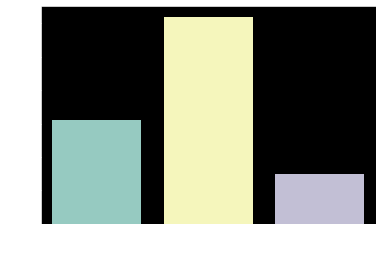

In [7]:
sns.countplot(x='target', data=df);

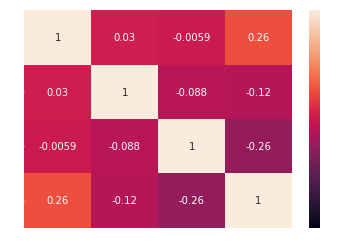

In [8]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

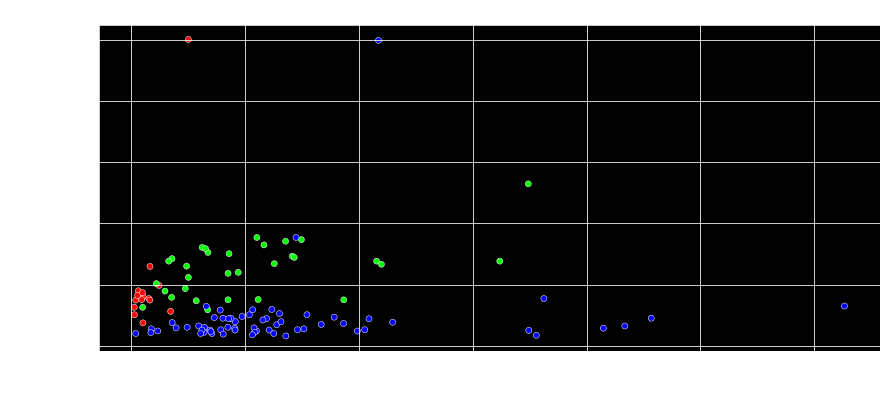

In [9]:
from sklearn.manifold import TSNE

possible_targets = list(set(df.target))

# X_embedded = TSNE(n_components=2, random_state=993).fit_transform(X)
# Тут можно взять ещё LDA или PCA (так как TSNE не умеет в простой transform)

def target_to_label(target_val):
    return data.target_names[int(target_val)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

ax.set_title('Dataset representation', fontsize=15)
ax.set_xlabel('Feature 1', fontsize=15)
ax.set_ylabel('Feature 2', rotation=0, labelpad=30, fontsize=15)
ax.grid()

colors = dict(zip(possible_targets, [(1, 0, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1), (1, 1, 0, 1), (1, 0, 1, 1), (0, 1, 1, 1), (1, 1, 1, 1)]))

sns.scatterplot(
    x=df['lonlat'],
    y=df['depth'],
    ax=ax,
    #hue=y
    c=list(map(colors.__getitem__, y))
);

In [10]:
import scipy.stats

def do(d, prefix, f):
    for i in d:
        if i == 'target': continue
        cur = f(d[i])
        label = prefix + i
        val = scipy.stats.normaltest(cur).pvalue
        txt = "{:.5f}".format(val)
        print('\t', label, ' ' * (16 - len(label)), "= ", txt, sep = '', end='')
        print(' ' * (16 - len(txt)), "ok" if val > 0.05 else "...", sep='')

for target in possible_targets:
    print(target)
    d = df[df.target == target]
    do(d, '', lambda x: x)
    do(d, 'ln ', np.log)

tEUSH
	lonlat          = 0.00239         ...
	depth           = 0.00000         ...
	dist            = 0.02625         ...
	depth?          = 0.58674         ok
	ln lonlat       = 0.93554         ok
	ln depth        = 0.00003         ...
	ln dist         = 0.87651         ok
	ln depth?       = 0.88257         ok
tCOGU
	lonlat          = 0.00061         ...
	depth           = 0.05046         ok
	dist            = 0.11305         ok
	depth?          = 0.07978         ok
	ln lonlat       = 0.51345         ok
	ln depth        = 0.68389         ok
	ln dist         = 0.21350         ok
	ln depth?       = 0.35478         ok
tRAZO
	lonlat          = 0.00000         ...
	depth           = 0.00000         ...
	dist            = 0.00000         ...
	depth?          = 0.08240         ok
	ln lonlat       = 0.00028         ...
	ln depth        = 0.00000         ...
	ln dist         = 0.00009         ...
	ln depth?       = 0.74086         ok


x:\python39\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score

# X_train, X_test, y_train, y_test = train_test_split(X, df.target, shuffle=True, random_state=30, stratify=y, test_size=0.2)

# Так как у нас только 150 объектов в общей выборке и исходные данные имеют природу отличную от текстов,
# то имеет смысл обучить такие алгоритмы, как:
# 1) KNeighborsClassifier;
# 2) SVC;
# 3) RandomForestClassifier (один из представителей ансамблевых методов).

# Инициализируем алгоритмы с параметрами по-умолчанию
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
forest_clf = RandomForestClassifier()

scorer = make_scorer(balanced_accuracy_score)

knn_acc_score = cross_val_score(knn_clf, X, y, cv=7, scoring=scorer).mean()
svm_acc_score = cross_val_score(svm_clf, X, y, cv=7, scoring=scorer).mean()
forest_acc_score = cross_val_score(forest_clf, X, y, cv=7, scoring=scorer).mean()

# Выведем алгоритмы по убыванию качества их работы
leaderboard = sorted([
    ('KNN', knn_acc_score),
    ('SVC', svm_acc_score),
    ('Forest', forest_acc_score)
], key=lambda pair: pair[1], reverse=True)

print('Leaderboard:')
for idx, (leader_name, leader_score) in enumerate(leaderboard):
    print(f'{idx + 1}.  {leader_name}:\t{leader_score}')

Leaderboard:
1.  Forest:	0.8253968253968254
2.  SVC:	0.620899470899471
3.  KNN:	0.6056878306878305
